In [1]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle # For rectangles
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
from scipy import stats # For linregress (trends)
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)

import sys
sys.path.insert(1, '/home/mlalande/notebooks') # to include my util file in previous directory
import utils as u # my personal functions
u.check_python_version()
u.check_virtual_memory()

3.8.2 | packaged by conda-forge | (default, Feb 28 2020, 17:15:22) 
[GCC 7.3.0]
Virtual memory usage - total: 252 GB / available: 190 GB / percent used: 24.5 %


# Check model data

In [2]:
var_LMDZ = 'precip'
folder_LMDZ = 'ATM'

# Define common period (remove 2 years at the beginning)
period = slice('1982','1990')

# Define zone
latlim=(10,50)
lonlim=(60,110)

var = 'pr'
label = 'Total precipitation'
units = 'mm/day'
cmap='DryWet'
levels=plot.arange(0,5,0.5)

In [3]:
path_GMTED2010 = '/data/mlalande/gpfsstore/rech/goe/ufz23bm/IGCM_OUT/LMDZOR/PROD/clim/clim-relief-GMTED2010-00625deg/'+folder_LMDZ+'/Output/MO'
model_GMTED2010 = xr.open_mfdataset(path_GMTED2010+'/*.nc', combine='by_coords')[var_LMDZ]
model_GMTED2010

<xarray.DataArray 'precip' (time_counter: 132, lat: 143, lon: 144)>
dask.array<concatenate, shape=(132, 143, 144), dtype=float32, chunksize=(12, 143, 144), chunktype=numpy.ndarray>
Coordinates:
  * lon            (lon) float32 -180.0 -177.5 -175.0 ... 172.5 175.0 177.5
  * lat            (lat) float32 90.0 88.73239 87.46479 ... -88.73239 -90.0
    time_instant   (time_counter) object dask.array<chunksize=(12,), meta=np.ndarray>
  * time_counter   (time_counter) object 1980-01-16 00:00:00 ... 1990-12-16 00:00:00
    time_centered  (time_counter) object dask.array<chunksize=(12,), meta=np.ndarray>
Attributes:
    long_name:           Precip Totale liq+sol
    units:               kg/(s*m2)
    online_operation:    average
    interval_operation:  900 s
    interval_write:      1 month
    cell_methods:        time: mean (interval: 900 s)

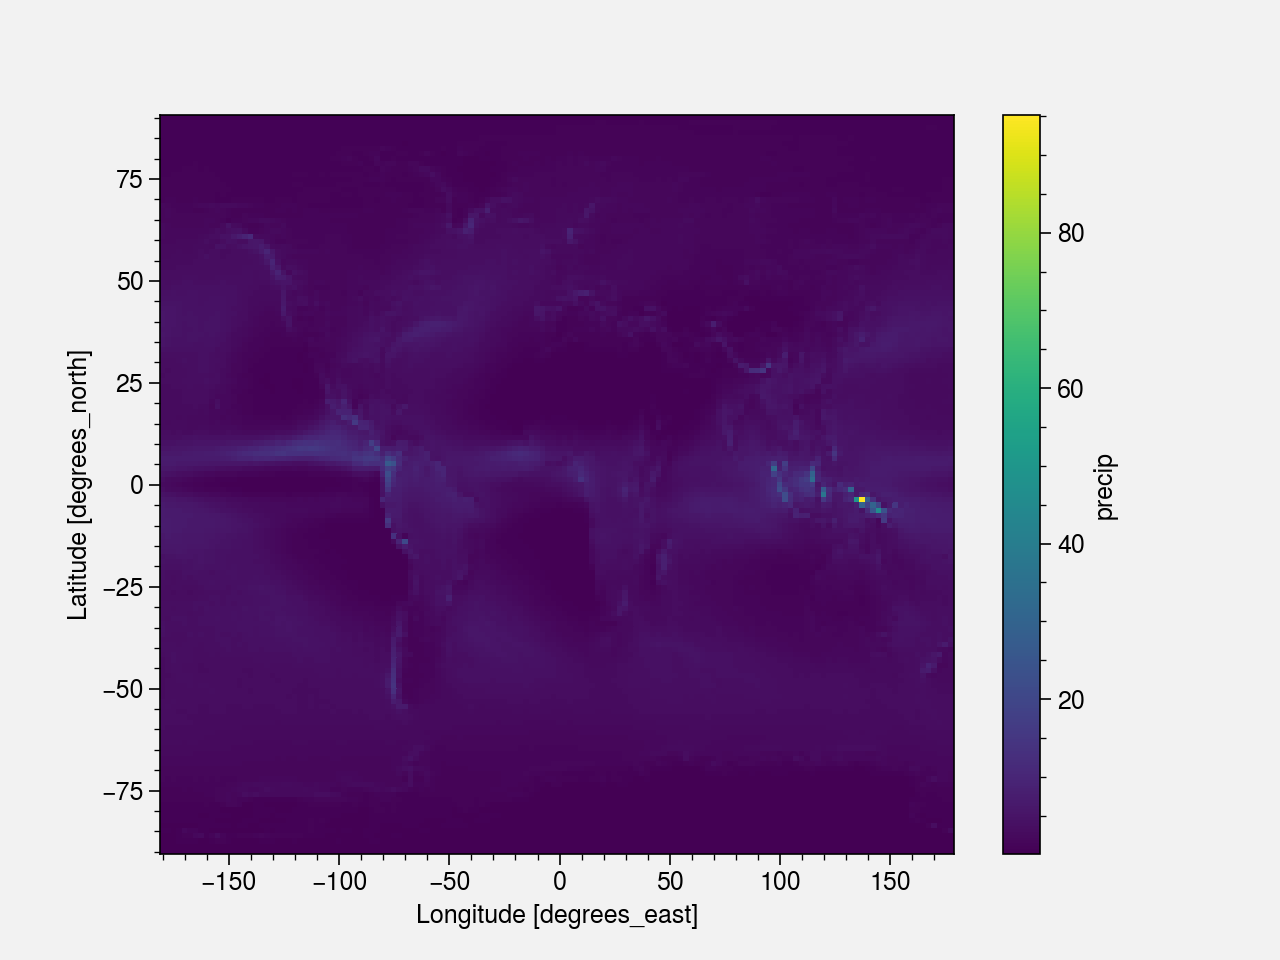

In [4]:
model_GMTED2010_clim = model_GMTED2010.sel(time_counter=period).mean('time_counter')*86400
model_GMTED2010_clim.plot()

In [5]:
path_def = '/data/mlalande/gpfsstore/rech/goe/ufz23bm/IGCM_OUT/LMDZOR/PROD/clim/clim-relief-def/'+folder_LMDZ+'/Output/MO'
model_def = xr.open_mfdataset(path_def+'/*.nc', combine='by_coords')[var_LMDZ]
model_def

<xarray.DataArray 'precip' (time_counter: 144, lat: 143, lon: 144)>
dask.array<concatenate, shape=(144, 143, 144), dtype=float32, chunksize=(12, 143, 144), chunktype=numpy.ndarray>
Coordinates:
  * lon            (lon) float32 -180.0 -177.5 -175.0 ... 172.5 175.0 177.5
  * lat            (lat) float32 90.0 88.73239 87.46479 ... -88.73239 -90.0
    time_instant   (time_counter) object dask.array<chunksize=(12,), meta=np.ndarray>
  * time_counter   (time_counter) object 1980-01-16 00:00:00 ... 1991-12-16 00:00:00
    time_centered  (time_counter) object dask.array<chunksize=(12,), meta=np.ndarray>
Attributes:
    long_name:           Precip Totale liq+sol
    units:               kg/(s*m2)
    online_operation:    average
    interval_operation:  900 s
    interval_write:      1 month
    cell_methods:        time: mean (interval: 900 s)

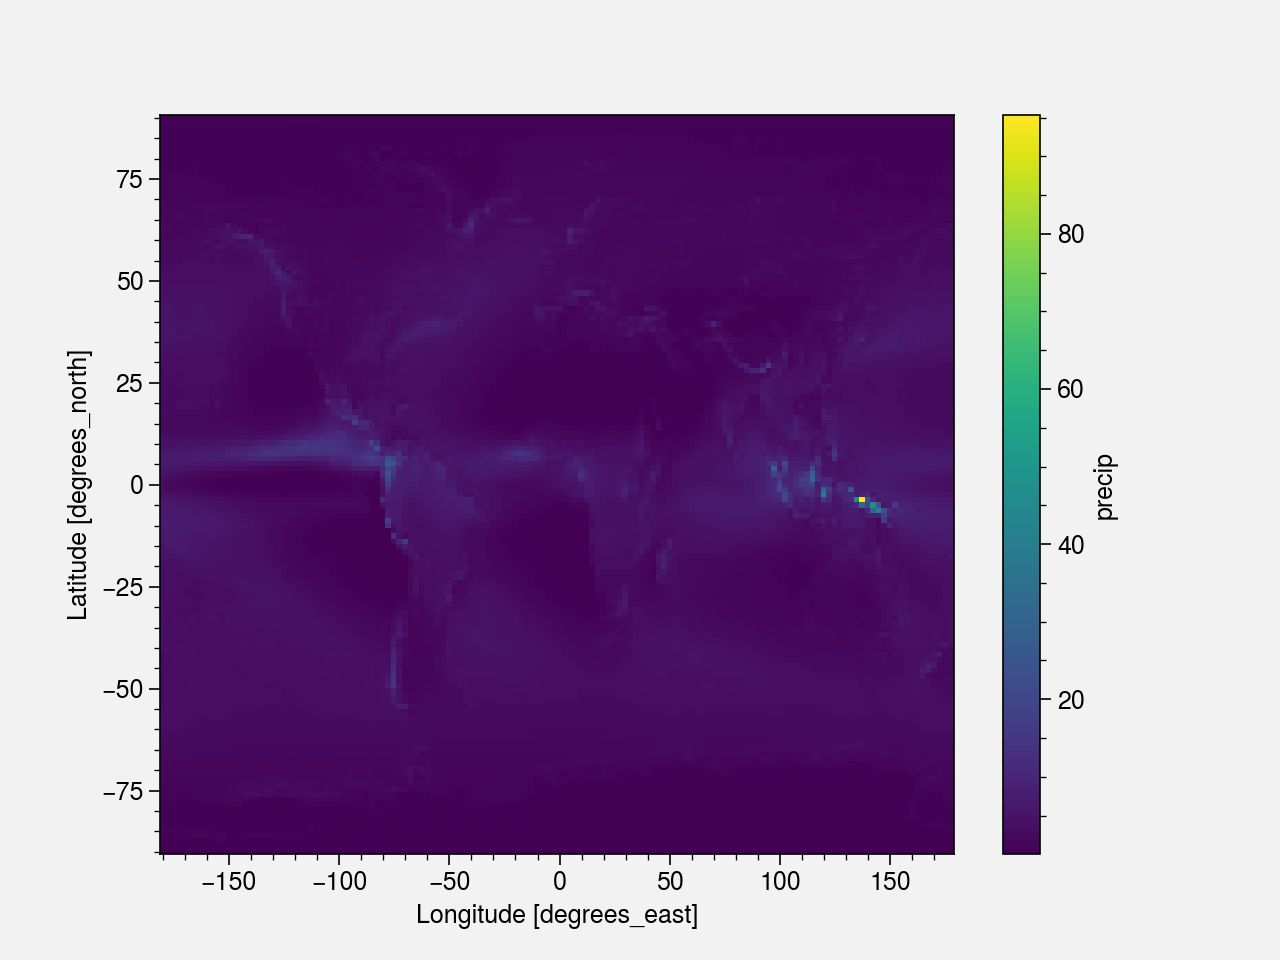

In [6]:
model_def_clim = model_def.sel(time_counter=period).mean('time_counter')*86400
model_def_clim.plot()

# Load obs
## APHRODITE http://aphrodite.st.hirosaki-u.ac.jp/download/data/search/  
http://aphrodite.st.hirosaki-u.ac.jp/download/
V1101 et V1101EX_R1 domain MA

http://localhost:7227/notebooks/notebooks/CICLAD/Himalaya/CMIP6_IPSL_bias/Precipitation.ipynb

/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


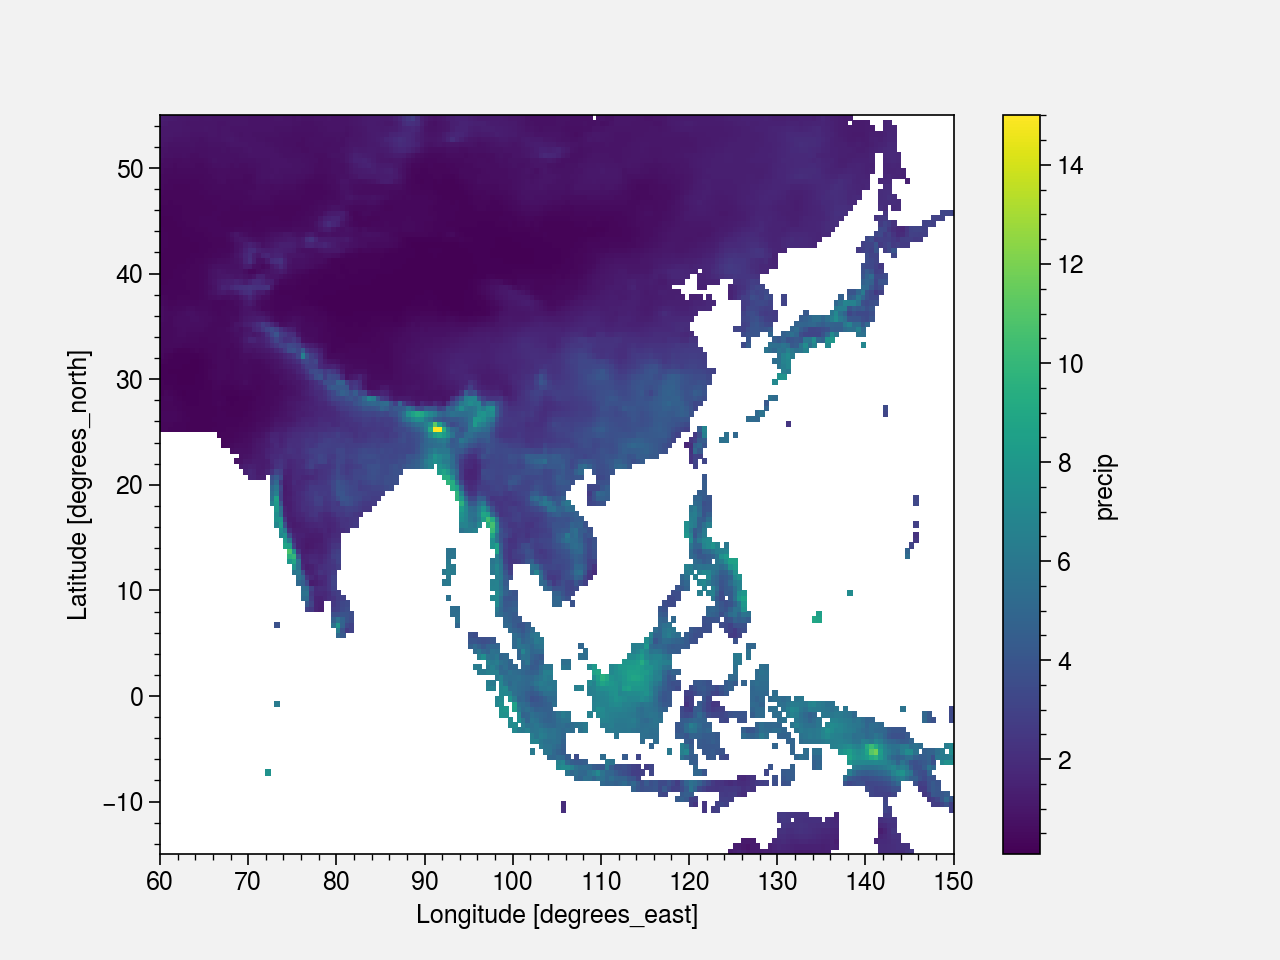

In [7]:
obs_longname = 'APHRODITE V1101 (0.5°)'
obs_name = 'APHRODITE'

obs_V1101 = xr.open_mfdataset(
    '/data/mlalande/APHRODITE/APHRO_MA_050deg_V1101.*.nc', combine='by_coords'
).precip
obs_V1101_EXR1 = xr.open_mfdataset(
    '/data/mlalande/APHRODITE/APHRO_MA_050deg_V1101_EXR1.*.nc', combine='by_coords'
).precip

obs_V1101 = obs_V1101.rename({'longitude': 'lon', 'latitude': 'lat'})
obs = xr.combine_nested([obs_V1101, obs_V1101_EXR1], concat_dim='time')
# Daily donc pas besoin de faire la clim en prenant en compte le nb de jours dans le mois
obs_clim = obs.sel(time=period).mean('time')
obs_clim.plot()

### Regrid using xESMF (https://xesmf.readthedocs.io/en/latest/) 

In [8]:
# For adding NaN values outside of the grid, otherwise it puts 0 (see issue just up #15)
import scipy
def add_matrix_NaNs(regridder):
    X = regridder.weights
    M = scipy.sparse.csr_matrix(X)
    num_nonzeros = np.diff(M.indptr)
    M[num_nonzeros == 0, 0] = np.NaN
    regridder.weights = scipy.sparse.coo_matrix(M)
    return regridder

regridder_obs = xe.Regridder(obs_clim, model_def_clim, 'bilinear', periodic=False, reuse_weights=True)
regridder_obs = add_matrix_NaNs(regridder_obs)
obs_clim_regrid = regridder_obs(obs_clim)

Reuse existing file: bilinear_140x180_143x144.nc


/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


# Plot differences

/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


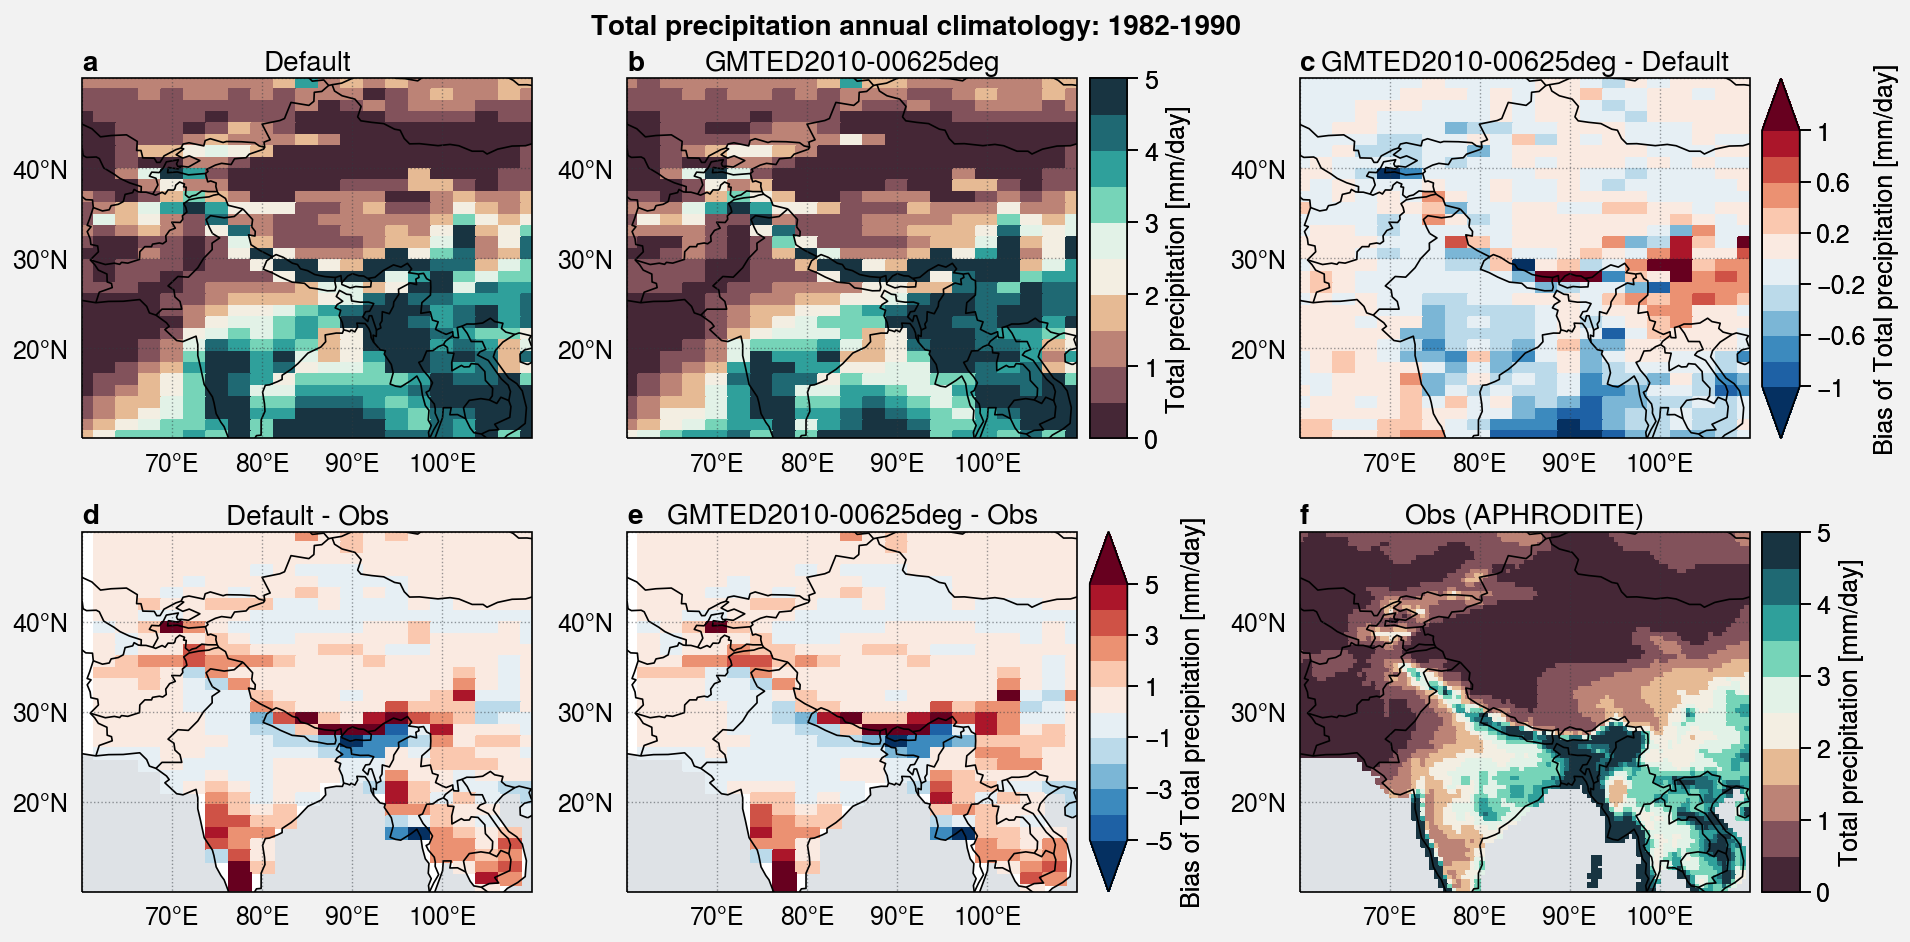

In [17]:
f, axs = plot.subplots(proj='cyl', ncols=3, nrows=2)

levels_diff = plot.arange(-1,1,0.2)
cmap_diff = 'BuRd'
extend_diff = 'both'

levels_bias = plot.arange(-5,5,1)
cmap_bias = 'BuRd'
extend_bias = 'both'

# First row: differences GMTED2010-00625deg / not guide
axs[0].pcolormesh(model_def_clim, cmap=cmap, levels=levels)
axs[0].format(title='Default')

m1 = axs[1].pcolormesh(model_GMTED2010_clim, cmap=cmap, levels=levels)
axs[1].format(title='GMTED2010-00625deg')
axs[1].colorbar(m1, label=label+ ' ['+units+']')

m2 = axs[2].pcolormesh(model_GMTED2010_clim - model_def_clim, cmap=cmap_diff, levels=levels_diff, extend=extend_diff)
axs[2].format(title='GMTED2010-00625deg - Default')
axs[2].colorbar(m2, label='Bias of '+label+ ' ['+units+']')


# Second row: differences with obs

m3 = axs[3].pcolormesh(model_def_clim - obs_clim_regrid, cmap=cmap_bias, levels=levels_bias, extend=extend_bias)
axs[3].format(title='Default - Obs')

axs[4].pcolormesh(model_GMTED2010_clim - obs_clim_regrid, cmap=cmap_bias, levels=levels_bias, extend=extend_bias)
axs[4].format(title='GMTED2010-00625deg - Obs')
axs[4].colorbar(m3, label='Bias of '+label+ ' ['+units+']')

axs[5].pcolormesh(obs_clim, cmap=cmap, levels=levels)
axs[5].format(title='Obs ('+obs_name+')')
axs[5].colorbar(m1, label=label+ ' ['+units+']')


axs.format(
    geogridlinewidth=0.5, geogridcolor='gray8', geogridalpha=0.5, labels=True, 
    coast=True, ocean=True, oceancolor='gray3', borders=True,
    suptitle=label+" annual climatology: "+period.start+"-"+period.stop,
    lonlines=10, latlines=10, abc=True, latlim=latlim, lonlim=lonlim
)

# f.save('img/'+var+'_relief_'+period.start+'-'+period.stop+'.jpg')
# f.save('img/'+var+'_relief_'+period.start+'-'+period.stop+'.png')
# f.save('img/'+var+'_relief_'+period.start+'-'+period.stop+'.pdf')

/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


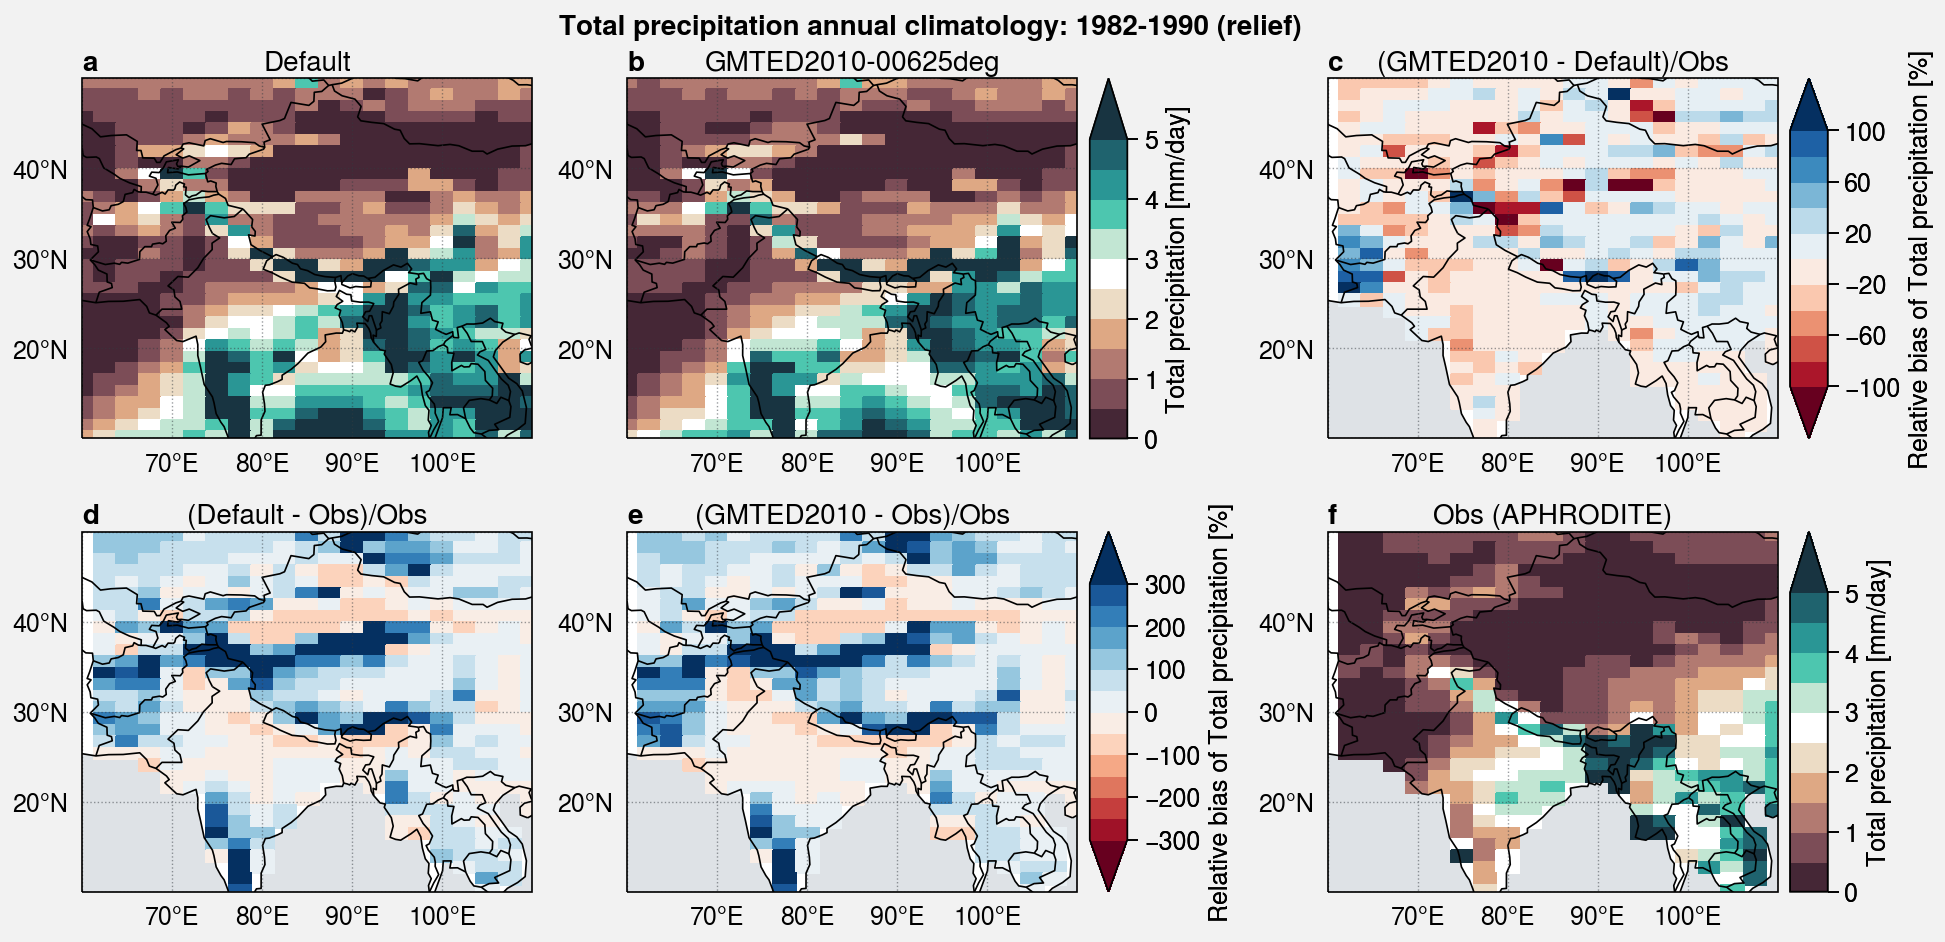

In [18]:
f, axs = plot.subplots(proj='cyl', ncols=3, nrows=2)

levels_diff = plot.arange(-100,100,20)
cmap_diff = 'BuRd_r'
extend_diff = 'both'

levels_bias = plot.arange(-300,300,50)
cmap_bias = 'BuRd_r'
extend_bias = 'both'

extend='max'

# First row: differences GMTED2010-00625deg / not guide
axs[0].pcolormesh(model_def_clim, cmap=cmap, levels=levels, extend=extend)
axs[0].format(title='Default')

m1 = axs[1].pcolormesh(model_GMTED2010_clim, cmap=cmap, levels=levels, extend=extend)
axs[1].format(title='GMTED2010-00625deg')
axs[1].colorbar(m1, label=label+ ' ['+units+']')

m2 = axs[2].pcolormesh((model_GMTED2010_clim - model_def_clim)/obs_clim_regrid*100, cmap=cmap_diff, levels=levels_diff, extend=extend_diff)
axs[2].format(title='(GMTED2010 - Default)/Obs')
axs[2].colorbar(m2, label='Relative bias of '+label+ ' [%]')


# Second row: differences with obs

m3 = axs[3].pcolormesh((model_def_clim - obs_clim_regrid)/obs_clim_regrid*100, cmap=cmap_bias, levels=levels_bias, extend=extend_bias)
axs[3].format(title='(Default - Obs)/Obs')

axs[4].pcolormesh((model_GMTED2010_clim - obs_clim_regrid)/obs_clim_regrid*100, cmap=cmap_bias, levels=levels_bias, extend=extend_bias)
axs[4].format(title='(GMTED2010 - Obs)/Obs')
axs[4].colorbar(m3, label='Relative bias of '+label+ ' [%]')

axs[5].pcolormesh(obs_clim_regrid, cmap=cmap, levels=levels, extend=extend)
axs[5].format(title='Obs ('+obs_name+')')
axs[5].colorbar(m1, label=label+ ' ['+units+']')


axs.format(
    geogridlinewidth=0.5, geogridcolor='gray8', geogridalpha=0.5, labels=True, 
    coast=True, ocean=True, oceancolor='gray3', borders=True,
    suptitle=label+" annual climatology: "+period.start+"-"+period.stop+" (relief)",
    lonlines=10, latlines=10, abc=True, latlim=latlim, lonlim=lonlim
)

# f.save('img/'+var+'_relative_relief_'+period.start+'-'+period.stop+'.jpg')
# f.save('img/'+var+'_relative_relief_'+period.start+'-'+period.stop+'.png')
# f.save('img/'+var+'_relative_relief_'+period.start+'-'+period.stop+'.pdf')